# Method 7 - Best Minus Rest

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Add Expected Returns from Intra-Cap Portfolio Weight per Shumway, Szefler, Yuan 2009

%store -r cap_exp_ret

valid_data = valid_data.merge(cap_exp_ret, on=['datadate', 'institution_id', 'fsym_id'], how='left')

# Calculate CSP Weight per Market Tilt

valid_data['adj_target'] = valid_data['expected_return']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

                                                                                         
# Split Long and Short and Filter to Highest Tilts

long_ideas = valid_data[valid_data['pos_rank'] == 1].copy()                                                                           
short_ideas = valid_data[valid_data['pos_rank'] != 1].copy()

# Weight the best ideas equally

long_ideas['target'] = 1 / long_ideas.groupby('datadate')[
    'institution_id'].transform('count')

short_ideas['target'] = - short_ideas['target'] / short_ideas.groupby([
    'datadate', 'institution_id'])['target'].transform('sum') * \
                        (1 / short_ideas.groupby('datadate')['institution_id']
                         .transform(lambda s: s.nunique()))

best_ideas = pd.concat([long_ideas, short_ideas])

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return.name = 'port_return'

## Plot Performance

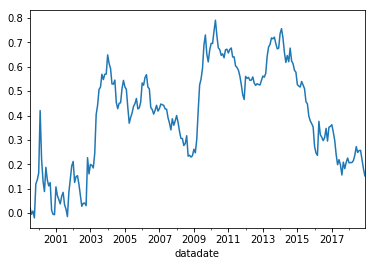

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.136050
2000-12-31   -0.125589
2001-12-31    0.201495
2002-12-31   -0.027679
2003-12-31    0.352765
2004-12-31   -0.016525
2005-12-31   -0.057135
2006-12-31   -0.025736
2007-12-31   -0.028498
2008-12-31   -0.103772
2009-12-31    0.350710
2010-12-31    0.002417
2011-12-31   -0.123301
2012-12-31    0.053104
2013-12-31    0.085757
2014-12-31   -0.058567
2015-12-31   -0.142520
2016-12-31    0.001710
2017-12-31   -0.095659
2018-12-31   -0.059800
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.636
Model:                            OLS   Adj. R-squared:                  0.629
Method:                 Least Squares   F-statistic:                     99.87
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.61e-49
Time:                        21:35:11   Log-Likelihood:                 546.44
No. Observations:                 234   AIC:                            -1083.
Df Residuals:                     229   BIC:                            -1066.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.002      1.538      0.125      -0.001       0.006
mktrf         -0.0969      0.044     -2.195      0.029      -0.184      -0.010
me             0.5091      0.051      9.911      0.000       0.408       0.610
ia             0.0103      0.078      0.132      0.895      -0.143       0.164
roe           -0.7635      0.067    -11.426      0.000      -0.895      -0.632
==============================================================================
Omnibus:                       53.441   Durbin-Watson:                   2.116
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              127.293
Skew:                           1.047   Prob(JB):                     2.28e-28
Kurtosis:                       5.944   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.636
Model:                            OLS   Adj. R-squared:                  0.629
Method:                 Least Squares   F-statistic:                     55.87
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.87e-33
Time:                        21:35:11   Log-Likelihood:                 546.44
No. Observations:                 234   AIC:                            -1083.
Df Residuals:                     229   BIC:                            -1066.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.002      1.434      0.151      -0.001       0.006
mktrf         -0.0969      0.042     -2.315      0.021      -0.179      -0.015
me             0.5091      0.093      5.470      0.000       0.327       0.691
ia             0.0103      0.121      0.085      0.932      -0.228       0.248
roe           -0.7635      0.115     -6.629      0.000      -0.989      -0.538
==============================================================================
Omnibus:                       53.441   Durbin-Watson:                   2.116
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              127.293
Skew:                           1.047   Prob(JB):                     2.28e-28
Kurtosis:                       5.944   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.636
Model:                            OLS   Adj. R-squared:                  0.629
Method:                 Least Squares   F-statistic:                     56.23
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.45e-33
Time:                        21:35:11   Log-Likelihood:                 546.44
No. Observations:                 234   AIC:                            -1083.
Df Residuals:                     229   BIC:                            -1066.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.002      1.350      0.177      -0.001       0.006
mktrf         -0.0969      0.042     -2.293      0.022      -0.180      -0.014
me             0.5091      0.103      4.950      0.000       0.308       0.711
ia             0.0103      0.121      0.085      0.932      -0.227       0.248
roe           -0.7635      0.121     -6.332      0.000      -1.000      -0.527
==============================================================================
Omnibus:                       53.441   Durbin-Watson:                   2.116
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              127.293
Skew:                           1.047   Prob(JB):                     2.28e-28
Kurtosis:                       5.944   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.621
Model:                            OLS   Adj. R-squared:                  0.613
Method:                 Least Squares   F-statistic:                     74.72
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.23e-46
Time:                        21:35:11   Log-Likelihood:                 541.83
No. Observations:                 234   AIC:                            -1072.
Df Residuals:                     228   BIC:                            -1051.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.002      0.982      0.327      -0.002       0.005
mktrf          0.0092      0.045      0.204      0.839      -0.080       0.098
smb            0.5177      0.060      8.676      0.000       0.400       0.635
hml           -0.0669      0.070     -0.951      0.342      -0.206       0.072
rmw           -0.6481      0.080     -8.148      0.000      -0.805      -0.491
cma            0.2440      0.101      2.414      0.017       0.045       0.443
==============================================================================
Omnibus:                       60.336   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              147.201
Skew:                           1.173   Prob(JB):                     1.09e-32
Kurtosis:                       6.097   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.621
Model:                            OLS   Adj. R-squared:                  0.613
Method:                 Least Squares   F-statistic:                     110.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.08e-59
Time:                        21:35:11   Log-Likelihood:                 541.83
No. Observations:                 234   AIC:                            -1072.
Df Residuals:                     228   BIC:                            -1051.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.002      0.899      0.369      -0.002       0.005
mktrf          0.0092      0.043      0.214      0.830      -0.075       0.094
smb            0.5177      0.070      7.406      0.000       0.381       0.655
hml           -0.0669      0.094     -0.714      0.475      -0.251       0.117
rmw           -0.6481      0.127     -5.115      0.000      -0.897      -0.400
cma            0.2440      0.148      1.644      0.100      -0.047       0.535
==============================================================================
Omnibus:                       60.336   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              147.201
Skew:                           1.173   Prob(JB):                     1.09e-32
Kurtosis:                       6.097   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.621
Model:                            OLS   Adj. R-squared:                  0.613
Method:                 Least Squares   F-statistic:                     114.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.36e-60
Time:                        21:35:11   Log-Likelihood:                 541.83
No. Observations:                 234   AIC:                            -1072.
Df Residuals:                     228   BIC:                            -1051.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.002      0.840      0.401      -0.002       0.005
mktrf          0.0092      0.045      0.205      0.837      -0.079       0.097
smb            0.5177      0.081      6.420      0.000       0.360       0.676
hml           -0.0669      0.080     -0.838      0.402      -0.223       0.090
rmw           -0.6481      0.139     -4.647      0.000      -0.922      -0.375
cma            0.2440      0.140      1.747      0.081      -0.030       0.518
==============================================================================
Omnibus:                       60.336   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              147.201
Skew:                           1.173   Prob(JB):                     1.09e-32
Kurtosis:                       6.097   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.575
Model:                            OLS   Adj. R-squared:                  0.568
Method:                 Least Squares   F-statistic:                     77.51
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.81e-41
Time:                        21:35:11   Log-Likelihood:                 528.47
No. Observations:                 234   AIC:                            -1047.
Df Residuals:                     229   BIC:                            -1030.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.381e-05      0.002      0.037      0.970      -0.003       0.003
mktrf          0.0439      0.044      0.999      0.319      -0.043       0.130
smb            0.8153      0.055     14.879      0.000       0.707       0.923
hml           -0.0874      0.054     -1.605      0.110      -0.195       0.020
umd           -0.2119      0.036     -5.934      0.000      -0.282      -0.142
==============================================================================
Omnibus:                       63.509   Durbin-Watson:                   2.098
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              231.556
Skew:                           1.072   Prob(JB):                     5.23e-51
Kurtosis:                       7.376   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.575
Model:                            OLS   Adj. R-squared:                  0.568
Method:                 Least Squares   F-statistic:                     25.02
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.36e-17
Time:                        21:35:11   Log-Likelihood:                 528.47
No. Observations:                 234   AIC:                            -1047.
Df Residuals:                     229   BIC:                            -1030.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.381e-05      0.002      0.039      0.969      -0.003       0.003
mktrf          0.0439      0.038      1.146      0.252      -0.031       0.119
smb            0.8153      0.091      8.931      0.000       0.636       0.994
hml           -0.0874      0.074     -1.189      0.235      -0.231       0.057
umd           -0.2119      0.062     -3.416      0.001      -0.334      -0.090
==============================================================================
Omnibus:                       63.509   Durbin-Watson:                   2.098
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              231.556
Skew:                           1.072   Prob(JB):                     5.23e-51
Kurtosis:                       7.376   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.575
Model:                            OLS   Adj. R-squared:                  0.568
Method:                 Least Squares   F-statistic:                     25.26
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.40e-17
Time:                        21:35:11   Log-Likelihood:                 528.47
No. Observations:                 234   AIC:                            -1047.
Df Residuals:                     229   BIC:                            -1030.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.381e-05      0.002      0.039      0.969      -0.003       0.003
mktrf          0.0439      0.037      1.191      0.234      -0.028       0.116
smb            0.8153      0.096      8.520      0.000       0.628       1.003
hml           -0.0874      0.068     -1.293      0.196      -0.220       0.045
umd           -0.2119      0.068     -3.136      0.002      -0.344      -0.079
==============================================================================
Omnibus:                       63.509   Durbin-Watson:                   2.098
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              231.556
Skew:                           1.072   Prob(JB):                     5.23e-51
Kurtosis:                       7.376   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.672
Model:                            OLS   Adj. R-squared:                  0.660
Method:                 Least Squares   F-statistic:                     58.83
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.06e-27
Time:                        21:35:11   Log-Likelihood:                 260.58
No. Observations:                 120   AIC:                            -511.2
Df Residuals:                     115   BIC:                            -497.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0048      0.003      1.793      0.076      -0.001       0.010
mktrf         -0.1039      0.073     -1.430      0.155      -0.248       0.040
me             0.5599      0.072      7.804      0.000       0.418       0.702
ia            -0.0874      0.112     -0.778      0.438      -0.310       0.135
roe           -0.7373      0.099     -7.415      0.000      -0.934      -0.540
==============================================================================
Omnibus:                       24.224   Durbin-Watson:                   2.129
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               40.471
Skew:                           0.918   Prob(JB):                     1.63e-09
Kurtosis:                       5.174   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.672
Model:                            OLS   Adj. R-squared:                  0.660
Method:                 Least Squares   F-statistic:                     84.10
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.12e-33
Time:                        21:35:11   Log-Likelihood:                 260.58
No. Observations:                 120   AIC:                            -511.2
Df Residuals:                     115   BIC:                            -497.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0048      0.003      1.610      0.107      -0.001       0.011
mktrf         -0.1039      0.067     -1.545      0.122      -0.236       0.028
me             0.5599      0.111      5.047      0.000       0.342       0.777
ia            -0.0874      0.168     -0.522      0.602      -0.416       0.241
roe           -0.7373      0.174     -4.227      0.000      -1.079      -0.395
==============================================================================
Omnibus:                       24.224   Durbin-Watson:                   2.129
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               40.471
Skew:                           0.918   Prob(JB):                     1.63e-09
Kurtosis:                       5.174   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.672
Model:                            OLS   Adj. R-squared:                  0.660
Method:                 Least Squares   F-statistic:                     93.27
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.59e-35
Time:                        21:35:11   Log-Likelihood:                 260.58
No. Observations:                 120   AIC:                            -511.2
Df Residuals:                     115   BIC:                            -497.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0048      0.003      1.507      0.132      -0.001       0.011
mktrf         -0.1039      0.069     -1.496      0.135      -0.240       0.032
me             0.5599      0.125      4.465      0.000       0.314       0.806
ia            -0.0874      0.160     -0.547      0.584      -0.400       0.226
roe           -0.7373      0.186     -3.956      0.000      -1.102      -0.372
==============================================================================
Omnibus:                       24.224   Durbin-Watson:                   2.129
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               40.471
Skew:                           0.918   Prob(JB):                     1.63e-09
Kurtosis:                       5.174   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.686
Model:                            OLS   Adj. R-squared:                  0.673
Method:                 Least Squares   F-statistic:                     49.89
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.83e-27
Time:                        21:35:11   Log-Likelihood:                 263.32
No. Observations:                 120   AIC:                            -514.6
Df Residuals:                     114   BIC:                            -497.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0047      0.003      1.715      0.089      -0.001       0.010
mktrf          0.0634      0.075      0.843      0.401      -0.086       0.212
smb            0.5768      0.085      6.773      0.000       0.408       0.745
hml           -0.1511      0.104     -1.448      0.150      -0.358       0.056
rmw           -0.5592      0.123     -4.544      0.000      -0.803      -0.315
cma            0.2488      0.135      1.845      0.068      -0.018       0.516
==============================================================================
Omnibus:                       25.420   Durbin-Watson:                   2.124
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               40.747
Skew:                           0.986   Prob(JB):                     1.42e-09
Kurtosis:                       5.064   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.686
Model:                            OLS   Adj. R-squared:                  0.673
Method:                 Least Squares   F-statistic:                     150.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.71e-48
Time:                        21:35:11   Log-Likelihood:                 263.32
No. Observations:                 120   AIC:                            -514.6
Df Residuals:                     114   BIC:                            -497.9
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0047      0.003      1.540      0.124      -0.001       0.011
mktrf          0.0634      0.065      0.969      0.332      -0.065       0.192
smb            0.5768      0.100      5.761      0.000       0.381       0.773
hml           -0.1511      0.120     -1.264      0.206      -0.385       0.083
rmw           -0.5592      0.189     -2.956      0.003      -0.930      -0.188
cma            0.2488      0.174      1.429      0.153      -0.092       0.590
==============================================================================
Omnibus:                       25.420   Durbin-Watson:                   2.124
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               40.747
Skew:                           0.986   Prob(JB):                     1.42e-09
Kurtosis:                       5.064   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.686
Model:                            OLS   Adj. R-squared:                  0.673
Method:                 Least Squares   F-statistic:                     224.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.07e-57
Time:                        21:35:11   Log-Likelihood:                 263.32
No. Observations:                 120   AIC:                            -514.6
Df Residuals:                     114   BIC:                            -497.9
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0047      0.003      1.379      0.168      -0.002       0.011
mktrf          0.0634      0.062      1.016      0.310      -0.059       0.186
smb            0.5768      0.115      5.025      0.000       0.352       0.802
hml           -0.1511      0.108     -1.402      0.161      -0.362       0.060
rmw           -0.5592      0.215     -2.607      0.009      -0.980      -0.139
cma            0.2488      0.152      1.640      0.101      -0.049       0.546
==============================================================================
Omnibus:                       25.420   Durbin-Watson:                   2.124
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               40.747
Skew:                           0.986   Prob(JB):                     1.42e-09
Kurtosis:                       5.064   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.671
Model:                            OLS   Adj. R-squared:                  0.659
Method:                 Least Squares   F-statistic:                     58.60
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.01e-27
Time:                        21:35:11   Log-Likelihood:                 260.43
No. Observations:                 120   AIC:                            -510.9
Df Residuals:                     115   BIC:                            -496.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.003      0.987      0.326      -0.003       0.008
mktrf          0.0758      0.064      1.183      0.239      -0.051       0.203
smb            0.8665      0.073     11.879      0.000       0.722       1.011
hml           -0.1496      0.073     -2.048      0.043      -0.294      -0.005
umd           -0.2065      0.045     -4.585      0.000      -0.296      -0.117
==============================================================================
Omnibus:                       32.150   Durbin-Watson:                   2.279
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               76.733
Skew:                           1.030   Prob(JB):                     2.18e-17
Kurtosis:                       6.332   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.671
Model:                            OLS   Adj. R-squared:                  0.659
Method:                 Least Squares   F-statistic:                     28.96
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.18e-16
Time:                        21:35:11   Log-Likelihood:                 260.43
No. Observations:                 120   AIC:                            -510.9
Df Residuals:                     115   BIC:                            -496.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.002      1.165      0.244      -0.002       0.007
mktrf          0.0758      0.047      1.606      0.108      -0.017       0.168
smb            0.8665      0.095      9.104      0.000       0.680       1.053
hml           -0.1496      0.100     -1.496      0.135      -0.346       0.046
umd           -0.2065      0.067     -3.086      0.002      -0.338      -0.075
==============================================================================
Omnibus:                       32.150   Durbin-Watson:                   2.279
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               76.733
Skew:                           1.030   Prob(JB):                     2.18e-17
Kurtosis:                       6.332   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.671
Model:                            OLS   Adj. R-squared:                  0.659
Method:                 Least Squares   F-statistic:                     30.25
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.41e-17
Time:                        21:35:11   Log-Likelihood:                 260.43
No. Observations:                 120   AIC:                            -510.9
Df Residuals:                     115   BIC:                            -496.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.002      1.200      0.230      -0.002       0.007
mktrf          0.0758      0.043      1.766      0.077      -0.008       0.160
smb            0.8665      0.098      8.861      0.000       0.675       1.058
hml           -0.1496      0.099     -1.512      0.130      -0.344       0.044
umd           -0.2065      0.072     -2.880      0.004      -0.347      -0.066
==============================================================================
Omnibus:                       32.150   Durbin-Watson:                   2.279
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               76.733
Skew:                           1.030   Prob(JB):                     2.18e-17
Kurtosis:                       6.332   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.567
Model:                            OLS   Adj. R-squared:                  0.551
Method:                 Least Squares   F-statistic:                     35.73
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.74e-19
Time:                        21:35:11   Log-Likelihood:                 306.56
No. Observations:                 114   AIC:                            -603.1
Df Residuals:                     109   BIC:                            -589.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0008      0.002     -0.501      0.617      -0.004       0.002
mktrf         -0.0255      0.049     -0.516      0.607      -0.123       0.072
me             0.2908      0.076      3.811      0.000       0.140       0.442
ia             0.2525      0.106      2.385      0.019       0.043       0.462
roe           -0.7733      0.093     -8.314      0.000      -0.958      -0.589
==============================================================================
Omnibus:                       23.368   Durbin-Watson:                   1.950
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               34.438
Skew:                           0.987   Prob(JB):                     3.33e-08
Kurtosis:                       4.831   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.567
Model:                            OLS   Adj. R-squared:                  0.551
Method:                 Least Squares   F-statistic:                     42.76
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.59e-21
Time:                        21:35:11   Log-Likelihood:                 306.56
No. Observations:                 114   AIC:                            -603.1
Df Residuals:                     109   BIC:                            -589.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0008      0.001     -0.681      0.496      -0.003       0.002
mktrf         -0.0255      0.043     -0.593      0.554      -0.110       0.059
me             0.2908      0.064      4.531      0.000       0.165       0.417
ia             0.2525      0.122      2.075      0.038       0.014       0.491
roe           -0.7733      0.133     -5.803      0.000      -1.035      -0.512
==============================================================================
Omnibus:                       23.368   Durbin-Watson:                   1.950
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               34.438
Skew:                           0.987   Prob(JB):                     3.33e-08
Kurtosis:                       4.831   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.567
Model:                            OLS   Adj. R-squared:                  0.551
Method:                 Least Squares   F-statistic:                     70.10
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.93e-29
Time:                        21:35:11   Log-Likelihood:                 306.56
No. Observations:                 114   AIC:                            -603.1
Df Residuals:                     109   BIC:                            -589.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0008      0.001     -0.760      0.447      -0.003       0.001
mktrf         -0.0255      0.036     -0.710      0.478      -0.096       0.045
me             0.2908      0.066      4.387      0.000       0.161       0.421
ia             0.2525      0.130      1.935      0.053      -0.003       0.508
roe           -0.7733      0.122     -6.361      0.000      -1.012      -0.535
==============================================================================
Omnibus:                       23.368   Durbin-Watson:                   1.950
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               34.438
Skew:                           0.987   Prob(JB):                     3.33e-08
Kurtosis:                       4.831   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.450
Model:                            OLS   Adj. R-squared:                  0.425
Method:                 Least Squares   F-statistic:                     17.69
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.02e-13
Time:                        21:35:11   Log-Likelihood:                 292.91
No. Observations:                 114   AIC:                            -573.8
Df Residuals:                     108   BIC:                            -557.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0021      0.002     -1.084      0.281      -0.006       0.002
mktrf          0.0185      0.053      0.346      0.730      -0.087       0.124
smb            0.3616      0.087      4.172      0.000       0.190       0.533
hml            0.1079      0.111      0.976      0.331      -0.111       0.327
rmw           -0.5618      0.135     -4.151      0.000      -0.830      -0.294
cma            0.2382      0.172      1.387      0.168      -0.102       0.579
==============================================================================
Omnibus:                       36.486   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               97.444
Skew:                           1.171   Prob(JB):                     6.92e-22
Kurtosis:                       6.877   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.450
Model:                            OLS   Adj. R-squared:                  0.425
Method:                 Least Squares   F-statistic:                     17.48
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.19e-12
Time:                        21:35:11   Log-Likelihood:                 292.91
No. Observations:                 114   AIC:                            -573.8
Df Residuals:                     108   BIC:                            -557.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0021      0.002     -1.230      0.219      -0.005       0.001
mktrf          0.0185      0.056      0.331      0.741      -0.091       0.128
smb            0.3616      0.069      5.227      0.000       0.226       0.497
hml            0.1079      0.086      1.255      0.209      -0.061       0.276
rmw           -0.5618      0.195     -2.877      0.004      -0.945      -0.179
cma            0.2382      0.150      1.588      0.112      -0.056       0.532
==============================================================================
Omnibus:                       36.486   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               97.444
Skew:                           1.171   Prob(JB):                     6.92e-22
Kurtosis:                       6.877   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.450
Model:                            OLS   Adj. R-squared:                  0.425
Method:                 Least Squares   F-statistic:                     23.26
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.60e-16
Time:                        21:35:11   Log-Likelihood:                 292.91
No. Observations:                 114   AIC:                            -573.8
Df Residuals:                     108   BIC:                            -557.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0021      0.001     -1.428      0.153      -0.005       0.001
mktrf          0.0185      0.059      0.312      0.755      -0.098       0.135
smb            0.3616      0.077      4.726      0.000       0.212       0.512
hml            0.1079      0.086      1.251      0.211      -0.061       0.277
rmw           -0.5618      0.206     -2.730      0.006      -0.965      -0.159
cma            0.2382      0.176      1.357      0.175      -0.106       0.582
==============================================================================
Omnibus:                       36.486   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               97.444
Skew:                           1.171   Prob(JB):                     6.92e-22
Kurtosis:                       6.877   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.389
Model:                            OLS   Adj. R-squared:                  0.367
Method:                 Least Squares   F-statistic:                     17.36
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.81e-11
Time:                        21:35:11   Log-Likelihood:                 286.90
No. Observations:                 114   AIC:                            -563.8
Df Residuals:                     109   BIC:                            -550.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0022      0.002     -1.133      0.260      -0.006       0.002
mktrf          0.0330      0.056      0.593      0.555      -0.077       0.143
smb            0.4882      0.087      5.626      0.000       0.316       0.660
hml            0.2273      0.089      2.544      0.012       0.050       0.404
umd           -0.1695      0.067     -2.514      0.013      -0.303      -0.036
==============================================================================
Omnibus:                       35.830   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              113.336
Skew:                           1.072   Prob(JB):                     2.45e-25
Kurtosis:                       7.389   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.389
Model:                            OLS   Adj. R-squared:                  0.367
Method:                 Least Squares   F-statistic:                     24.99
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.06e-14
Time:                        21:35:11   Log-Likelihood:                 286.90
No. Observations:                 114   AIC:                            -563.8
Df Residuals:                     109   BIC:                            -550.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0022      0.002     -1.294      0.196      -0.006       0.001
mktrf          0.0330      0.057      0.581      0.561      -0.078       0.144
smb            0.4882      0.073      6.649      0.000       0.344       0.632
hml            0.2273      0.094      2.416      0.016       0.043       0.412
umd           -0.1695      0.049     -3.432      0.001      -0.266      -0.073
==============================================================================
Omnibus:                       35.830   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              113.336
Skew:                           1.072   Prob(JB):                     2.45e-25
Kurtosis:                       7.389   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.389
Model:                            OLS   Adj. R-squared:                  0.367
Method:                 Least Squares   F-statistic:                     33.92
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.26e-18
Time:                        21:35:11   Log-Likelihood:                 286.90
No. Observations:                 114   AIC:                            -563.8
Df Residuals:                     109   BIC:                            -550.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0022      0.002     -1.284      0.199      -0.006       0.001
mktrf          0.0330      0.056      0.589      0.556      -0.077       0.143
smb            0.4882      0.056      8.751      0.000       0.379       0.598
hml            0.2273      0.091      2.501      0.012       0.049       0.405
umd           -0.1695      0.038     -4.424      0.000      -0.245      -0.094
==============================================================================
Omnibus:                       35.830   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              113.336
Skew:                           1.072   Prob(JB):                     2.45e-25
Kurtosis:                       7.389   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""